In [ ]:
# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import os # Configure which GPU
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) # Avoid warnings from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.random.set_seed(1) # Set global random seed for reproducibility

2023-06-25 23:13:06.094170: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 23:13:06.154879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 23:13:07.072549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image

# Import Sionna
import sionna

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Paths2CIR

# # For link-level simulations
# from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
# from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
# from sionna.utils import compute_ber, ebnodb2no, PlotBER
# from sionna.ofdm import KBestDetector, LinearDetector
# from sionna.mimo import StreamManagement

In [6]:
def get_data_from_HeightFile(line):
    line = line.replace('(', '')
    line = line.replace(')', '')
    line = line.replace('\n', '')
    line = line.split(',')
    f_name = line[-1]
    line = line[0:-1]  # disregard FileName
    # file format: (minLon, maxLat, maxLon, minLat), building_to_area ratio, height, name
    minLonOut, maxLatOut, maxLonOut, minLatOut, percent, height = [float(l) for l in line]
    return minLonOut, maxLatOut, maxLonOut, minLatOut, percent, height, f_name


def cm_routine(extra_height, outer_lines, outer_idx, seed):
    _,_,_,_,_, height_at_origin, file_name = get_data_from_HeightFile(outer_lines[outer_idx])
    scene = load_scene('Blender_stuff2/temp/' + file_name + '/' + file_name + '.xml')
    scene.tx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="tr38901",
                              polarization="VH")

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(num_rows=1,
                              num_cols=1,
                              vertical_spacing=0.5,
                              horizontal_spacing=0.5,
                              pattern="iso",
                              polarization="cross")
    # Add a transmitter
    tx = Transmitter(name="tx",
                  position=[0,0,height_at_origin+5],
                  orientation=[0,0,0])
    scene.add(tx)
    scene.frequency = 2.14e9 # in Hz; implicitly updates RadioMaterials
    scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)
    
    # Compute coverage map
    cm = scene.coverage_map(max_depth=8, cm_center=[0, 0, height_at_origin+extraHeight], cm_orientation=[0,0,0], 
                            cm_size=[1000,1000], seed=seed)
    # Visualize coverage in preview
    # scene.preview(coverage_map=cm, resolution=[1000, 600])
    return cm, scene, file_name


def save_routine(cm, img_path):
    cm_tensor = cm.as_tensor()
    cm_2D = cm_tensor.numpy()[0, :, :]
    cm_2D[cm_2D == 0] = np.nan
    cm_2D_dB = 10*np.log10(cm_2D)
    cm_img = Image.fromarray(cm_2D_dB)
    cm_img.save(img_path)
    return


extraHeight = 2  # additional height to add to height above ground

f_Height = open('Blender_stuff2/HeightAtOrigin.txt', 'r')
lines = f_Height.readlines()
cm, scene, file_name = cm_routine(extra_height=2, outer_lines=lines, outer_idx=0, seed=0)

tf.Tensor(
[[1.5455997e-05 2.4007197e-04 4.3804632e-03 3.5625044e-03]
 [4.6659334e-05 6.0948338e-03 4.7348106e-01 2.7548620e-02]
 [3.5103418e-05 4.3415476e-04 1.2548572e-01 2.0823739e-02]
 [9.8621840e-06 1.4784524e-05 7.9103943e-04 2.0637882e-03]], shape=(4, 4), dtype=float32)
0.47348106


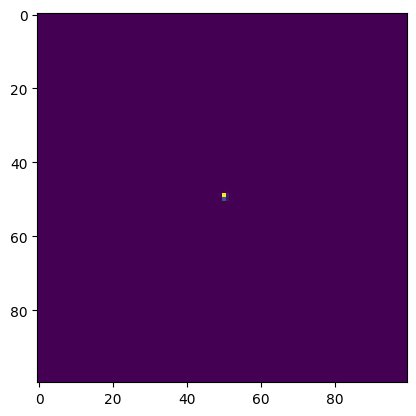

In [8]:
cm_arr = cm.as_tensor()[0, :, :]
plt.imshow(cm_arr)
print(cm_arr[48:52, 48:52])
print(np.max(cm_arr))

In [44]:
for idx in range(len(lines)):
    coverage_map, scene, fName = cm_routine(extra_height=extraHeight, outer_lines=lines, outer_idx=idx, seed=idx)
    print(fName)
    image_path = 'Sionna_coverage_maps2/' + fName + '.tiff'
    save_routine(coverage_map, image_path)

# idx = 3
# cm, scene, fName = cm_routine(dir_name=dir_folders[idx], extra_height=extraHeight, outer_lines=lines, outer_idx=idx)

601_7fd557a3-76d9-483a-802d-3c309c373084
602_ad938775-0813-4ef8-aeb3-3d3c45757fe8
603_a79834e7-2949-44d7-9b7e-2cd492879880
604_ca092f5f-2bba-4a55-aafd-a62b3fd2672c
605_2535aad6-28f6-4e8d-b2cb-929930db1d7f
606_27dfdc9f-696f-498f-86c5-86c6abba716d
607_8da3c241-13c9-44dc-90aa-55793b56ebf9
608_64ecc7d4-2f26-400f-b719-e56564d091a0
609_36ba20a0-2e68-4d9e-8cd4-67dc9ed84751
610_29fc98e7-6ab8-43bc-9ba9-52c4dd87c461
611_15831c67-1cd3-4303-8d76-0aa76ff73374
612_5b0ab68b-38b9-44c7-bcd5-68d80c24ceea
615_9dcf6c19-22a3-456b-9482-a69f7f16ca51
618_a9a893db-6f83-45f1-9c00-076e6c538a13
619_1b081bb6-dff5-468c-a79c-73775d88048d
620_c1b3791e-edef-4410-ad17-358ea90da9e3
621_5d13873b-6f02-468b-83d5-5d42024a36b1
622_bd2d4361-1211-446e-9ed2-98faecdf4cf2
623_89a5c682-d383-4d16-8d5a-b79a7eb2aa99
624_bf0dd8ed-5eef-4ef8-8e77-8f62038a4f34
625_21c6b641-9f7c-46cb-910d-a7f0784eca4b
626_f785408f-2934-4d98-8d15-650f05608d92
627_62d607ad-bfe0-414b-8f2b-2fc71f7d6895
630_a67c470e-e054-4271-8f8e-5e85724e8963


In [19]:
# Testing to see if the values are right.
from PIL import Image
test_arr = np.array(Image.open('Sionna_coverage_maps/2109_deaf03cf-8682-4649-9d0a-f8ce20641204.tiff'))
test_arr[0, :]

array([        nan,         nan,         nan, -123.76938 ,         nan,
               nan,         nan, -123.12446 ,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan, -124.46883 ,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, -118.504326,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       -117.31752 , -116.546265,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [46]:
cm, scene, fName = cm_routine(extra_height=2, outer_lines=lines, outer_idx=4, seed=4)

In [47]:
cm_tens = cm.as_tensor()
# convert to numpy
cm_2D = cm_tens.numpy()[0, :, :]
# convert to path loss

In [48]:
cm_2D[cm_2D == 0] = np.nan
cm_2D = 10*np.log10(cm_2D)
print(cm_2D.shape)

(100, 100)


nan nan


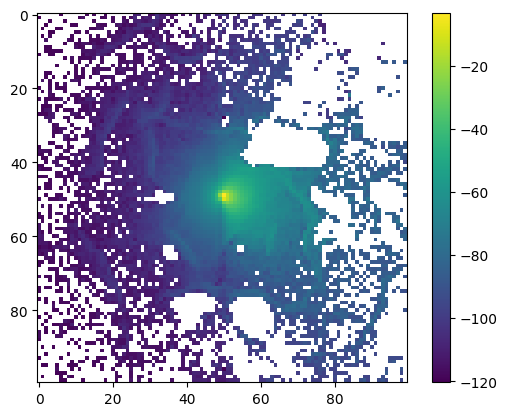

In [49]:
cm_img = Image.fromarray(cm_2D)
# cm_img.save('Sionna_coverage_maps/testImg.tiff')
# if colab_compat:
#     scene.render(camera="scene-cam-0", num_samples=512);
#     raise ExitCell
# scene.preview()
print(np.max(cm_2D), np.min(cm_2D))
fig, ax = plt.subplots(1, 1)
plt.imshow(cm_2D)
#plt.colorbar(cax=ax)
plt.colorbar()

In [50]:
# print(cm_2D[45:55, 45:55])
print(cm_2D[0, :])
scene.preview(coverage_map=cm, resolution=[1000, 600])
# cm.show()

[        nan         nan         nan         nan         nan         nan
 -118.91556          nan         nan         nan         nan         nan
         nan -118.02712          nan -117.75755          nan         nan
 -117.34177          nan         nan         nan         nan         nan
         nan         nan -109.63441  -108.159            nan         nan
 -116.93666  -113.74887  -103.09754  -110.489914 -110.61453  -111.92174
 -115.373535 -115.311935         nan -114.92824          nan -113.44147
         nan -108.90051          nan -108.9719   -106.575806         nan
 -107.82013  -102.92157  -101.14323  -105.55732          nan         nan
 -105.04567          nan         nan         nan -103.089325 -102.821205
 -102.09219          nan         nan         nan         nan         nan
 -102.15544          nan         nan  -99.43785          nan         nan
  -98.54021          nan         nan         nan  -98.50822          nan
         nan         nan         nan         nan     

Renderer(camera=PerspectiveCamera(aspect=1.6666666666666667, children=(DirectionalLight(intensity=0.25, positi…

In [ ]:
scene.tx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="tr38901",
                          polarization="VH")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="iso",
                          polarization="cross")
# Add a transmitter
tx = Transmitter(name="tx",
              position=[0,0,height_file1626+5],
              orientation=[0,0,0])
scene.add(tx)

# Compute coverage map
cm = scene.coverage_map(max_depth=8, cm_center=[0, 0, height_file1626+extraHeight], cm_orientation=[0,0,0], 
                        cm_size=[1000,1000])

# Visualize coverage in preview
scene.preview(coverage_map=cm, resolution=[1000, 600])

In [ ]:
print(height_file1626)

In [ ]:
cm.show()

In [13]:
temp_arr = np.load('Sionna_coverage_maps/coverage_maps_new_building_map_test/0_f96f2893-4bc0-4c80-9848-ed399f4f8d6e.npy')
temp_arr[temp_arr==0] = 10**-12

162.62863 -155.89575


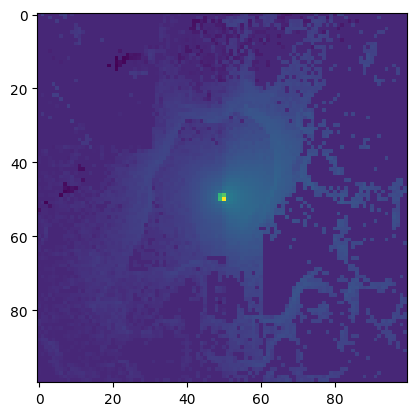

In [14]:
log_temp_arr = 10*np.log10(temp_arr)
plt.imshow(log_temp_arr)
print(np.max(log_temp_arr), np.min(log_temp_arr))

In [2]:
f_Height = open('/home/yl826/3DPathLoss/nc_raytracing/res/height_at_origin/16_4d2e191d-23d1-4d15-b1d0-e66f8caede79.txt', 'r')
lines = f_Height.readlines()
cm, scene, file_name = cm_routine(extra_height=2, outer_lines=lines, outer_idx=0, seed=0)

NameError: name 'cm_routine' is not defined